Import the tables into the code

In [1]:
from astropy.table import Table

In [2]:
Group_tab = Table.read("SDSS_Tempel_ggfits/GG_list.fits")

Gal_tab = Table.read("SDSS_Tempel_ggfits/GAL_table.fits")

Filter the tables into useful tables by removing all groups where Ngal < 3

In [3]:
Gal_tab = Gal_tab.group_by(['Ngal'])
mask = Gal_tab.groups.keys['Ngal'] > 2
Gal_tab = Gal_tab.groups[mask]

In [4]:
Gal_groupped = Gal_tab.group_by(['GroupID'])

First step to to finding velocity dispersions is to find the velocities and the mean velocity in a group using v=(z-z_avg)c and then secondly we calculate std deviation and finally gapper

In [5]:
import numpy as np
std = []
gap = []
for i in range(0,len(Gal_groupped.groups.keys)):
    gal_v = []
    Group = Gal_groupped.groups[i]
    z_avg = np.mean(Group['zcmb'])
    for j in range(0, Group['Ngal'][0]):
        gal_v.append((Group['zcmb'][j]-z_avg)*299792)
    avg_v = np.average(gal_v)
    std_temp = 0
    gap_temp = 0
    temp_sum = 0
    for j in range(0, Group['Ngal'][0]):
        temp_sum = temp_sum + (gal_v[j]-avg_v)**2
    std_temp = np.sqrt((1/((Group['Ngal'][0]-1)*(1+z_avg)**2))*temp_sum)
    std.append(std_temp)
    temp_sum = 0
    gal_v.sort()
    for j in range(0, Group['Ngal'][0]-1):
        gi = 0
        wi = 0
        gi = gal_v[j+1]-gal_v[j]
        wi = (j+1)*(Group['Ngal'][0]-(j+1))
        temp_sum = temp_sum + (gi*wi)
    gap_temp = (np.sqrt(np.pi)/(Group['Ngal'][0]*(Group['Ngal'][0]-1)*(1+z_avg)))*temp_sum
    gap.append(gap_temp)

In [6]:
gap_arr = np.array(gap)
std_arr = np.array(std)
std_gap = np.hstack((std_arr[0:], gap_arr[0:]))
std_gap = np.reshape(std_gap, newshape=(len(std_arr), 2), order='F')
std_gap

array([[238.6733003 , 230.52818932],
       [299.24457574, 321.64232676],
       [650.61655576, 640.70452282],
       ...,
       [153.43255406, 179.74407651],
       [ 27.78757725,  28.96986781],
       [ 20.93924602,  20.8807973 ]])

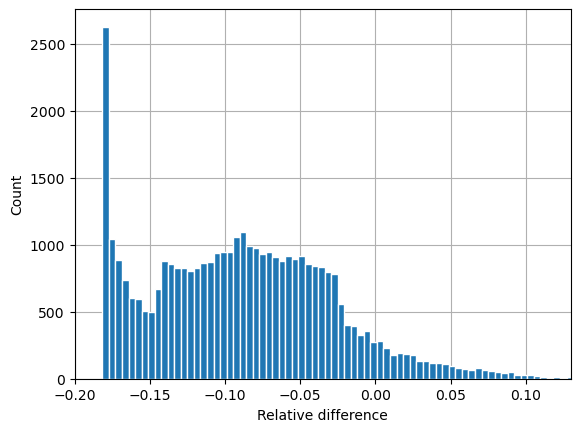

In [14]:
import matplotlib.pyplot as plt

def rel_diff(std, gap):
    rel_diff = (std-gap)/std
    return rel_diff

hist_data = np.array([])
for i in range(0, len(Gal_groupped.groups.keys)):
    hist_data = np.append(hist_data, rel_diff(std_gap[i][0], std_gap[i][1]))
    

fig, ax = plt.subplots()
ax.set_axisbelow(True)
ax.grid()
ax.hist(hist_data, bins=100, edgecolor='white')
ax.set_ylabel('Count')
ax.set_xlabel('Relative difference')
ax.set(xlim=(-0.2, 0.13))
plt.show()

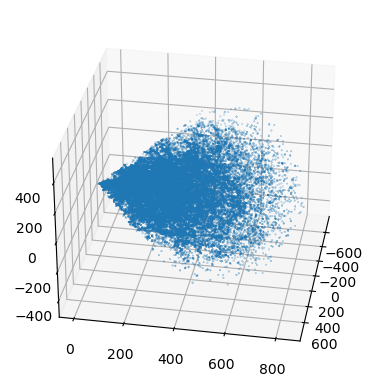

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.view_init(elev=30, azim=10, roll=0)
sc = ax.scatter(Gal_tab['Xpos'], Gal_tab['Ypos'], Gal_tab['Zpos'], marker='o', s=0.01)
plt.show()

This is a mapping of all the galaxies in the catalogue